In [4]:
import json
import pandas as pd
import os
data_path = 'data/ir-lymphoma-data'
#data_path = 'data/ireceptor/ir-covid-19-global-patterns6/'
tsv_file = data_path + '/ireceptor-public-archive.tsv'
#tsv_file = data_path + 'roche.tsv'
meta_data = data_path + '/ireceptor-public-archive-metadata.json'
#meta_data = data_path + 'roche-metadata.json'

In [5]:
# questions: how many colums are in the file, how many rows
# how many columns have data, how do you count clonality, 
# how do you get additonal meta data for each row. e.g does have cases and controls listed. 

with open(meta_data) as json_file:
    data = json.load(json_file)

print("Type:", type(data))

# want the data within Repertoire
meta_df = pd.json_normalize(data['Repertoire'])

#print(meta_df)
diag_df = meta_df[['repertoire_id', 'subject.diagnosis']].copy()

diag_df['subject.diagnosis'] = diag_df['subject.diagnosis']\
    .apply(lambda x: ''.join([item["study_group_description"] for item in x]))

print(meta_df)
print(diag_df)
print(diag_df['subject.diagnosis'].value_counts())

Type: <class 'dict'>
   repertoire_id repertoire_name repertoire_description  \
0             10            None                   None   
1             16            None                   None   
2             27            None                   None   
3             38            None                   None   
4             42            None                   None   
..           ...             ...                    ...   
71           507            None                   None   
72           508            None                   None   
73           519            None                   None   
74           525            None                   None   
75           526            None                   None   

                                               sample  \
0   [{'sample_processing_id': '354', 'sample_id': ...   
1   [{'sample_processing_id': '318', 'sample_id': ...   
2   [{'sample_processing_id': '325', 'sample_id': ...   
3   [{'sample_processing_id': '329', 'samp

In [10]:
seqs_df = pd.read_csv(tsv_file, sep='\t')
seqs_df.dropna(how= "all", axis=1, inplace=True)

In [11]:
# merge rep_id_diagnosis with seq_data
#r, c = seqs_df.shape
#print(r,c, "\n", seq_data_df['repertoire_id'])

diag_df['repertoire_id'] = diag_df['repertoire_id'].astype(int) #cast needed for lymphoma data

seqs_diag = pd.merge(diag_df, seqs_df, on='repertoire_id', how='left')
# Rename the 'subject.diagnosis' column to 'diagnosis'
seqs_diag.rename(columns={'subject.diagnosis': 'diagnosis'}, inplace=True)

grouped_data = seqs_diag.groupby(['repertoire_id', 'diagnosis']).size().reset_index(name='count')
print(grouped_data)

    repertoire_id          diagnosis  count
0              10               Case   6464
1              16               Case   6315
2              27               Case   8243
3              38               Case   5457
4              42  Control (Healthy)   7622
..            ...                ...    ...
71            507  Control (Healthy)   6585
72            508  Control (Healthy)   7684
73            519               Case  33536
74            525  Control (Healthy)   7850
75            526               Case  25403

[76 rows x 3 columns]


In [12]:
list(seqs_diag)

['repertoire_id',
 'diagnosis',
 'sequence',
 'rev_comp',
 'productive',
 'locus',
 'v_call',
 'd_call',
 'j_call',
 'junction',
 'junction_aa',
 'v_score',
 'j_score',
 'cdr1_start',
 'cdr1_end',
 'cdr2_start',
 'cdr2_end',
 'cdr3_start',
 'cdr3_end',
 'fwr1_start',
 'fwr1_end',
 'fwr2_start',
 'fwr2_end',
 'fwr3_start',
 'fwr3_end',
 'fwr4_start',
 'fwr4_end',
 'junction_length',
 'junction_aa_length',
 'sequence_id',
 'v_subgroup',
 'v_gene',
 'j_subgroup',
 'j_gene',
 'd_subgroup',
 'd_gene']

In [21]:
# Step 0: Group the data by 'repertoire_id' and 'v_subgroup' and calculate the count
grouped_data = seqs_diag.groupby(['repertoire_id', 'diagnosis', 'v_subgroup']).size().reset_index(name='count')

# Step 2: Calculate the total count for each 'repertoire_id'
total_counts = grouped_data.groupby('repertoire_id')['count'].sum()

# Step 3: Merge the total_counts back into the grouped_data DataFrame
grouped_data = grouped_data.merge(total_counts, on='repertoire_id', suffixes=('', '_total'))

# Step 4: Calculate the relative frequency by dividing count by the total count for each group
grouped_data['relative_frequency'] = grouped_data['count'] / grouped_data['count_total']

# Step 5: Drop the 'count_total' column (if needed) since it's no longer needed in the final result
grouped_data.drop(columns=['count_total'], inplace=True)

# Step 6: Print the resulting DataFrame
print(grouped_data)

     repertoire_id diagnosis       v_subgroup  count  relative_frequency
0               10      Case            IGHV1     79            0.012445
1               10      Case            IGHV2      9            0.001418
2               10      Case            IGHV3   6128            0.965343
3               10      Case            IGHV4    124            0.019534
4               10      Case            IGHV5      6            0.000945
..             ...       ...              ...    ...                 ...
564            526      Case            IGHV4    938            0.038443
565            526      Case            IGHV5  19936            0.817049
566            526      Case            IGHV6      8            0.000328
567            526      Case            IGHV7     65            0.002664
568            526      Case  IGHV7, or IGHV5      1            0.000041

[569 rows x 5 columns]


In [18]:
# Step 0: Group the data by 'repertoire_id' and 'v_subgroup' and calculate the count
grouped_data = seqs_diag.groupby(['repertoire_id', 'diagnosis', 'v_subgroup']).size().reset_index(name='count')

# Step 1: Calculate the total count for each 'repertoire_id'
total_counts = grouped_data.groupby('repertoire_id')['count'].sum()

# Step 2: Merge the total_counts back into the grouped_data DataFrame
grouped_data = grouped_data.merge(total_counts, on='repertoire_id', suffixes=('', '_total'))

# Step 3: Calculate the relative frequency by dividing count by the total count for each group
grouped_data['relative_frequency'] = grouped_data['count'] / grouped_data['count_total']

# Step 4: Find the maximum relative frequency for each 'repertoire_id'
max_relative_freq_per_repertoire = grouped_data.groupby('repertoire_id')['relative_frequency'].max()

# Step 5: Create a DataFrame to store the result with 'repertoire_id', 
#'v_subgroup', and 'max_relative_frequency'
result_df = grouped_data.loc[grouped_data.groupby('repertoire_id')
            ['relative_frequency'].idxmax()].reset_index(drop=True)

# Step 6: Merge the 'max_relative_frequency' column from 'max_relative_freq_per_repertoire' into 'result_df'
result_df['max_relative_frequency'] = max_relative_freq_per_repertoire.values

# Step 7: Print the result DataFrame
pd.set_option('display.max_columns', None)  # or 1000, None for all
pd.set_option('display.max_rows', 50)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199
selected_columns = ['repertoire_id', 'diagnosis', 'v_subgroup', 'max_relative_frequency']
print(result_df[selected_columns])
pd.reset_option('display.max_rows')

    repertoire_id          diagnosis v_subgroup  max_relative_frequency
0              10               Case      IGHV3                0.965343
1              16               Case      IGHV3                0.997780
2              27               Case      IGHV3                0.970986
3              38               Case      IGHV1                0.997950
4              42  Control (Healthy)      IGHV4                0.356045
..            ...                ...        ...                     ...
71            507  Control (Healthy)      IGHV4                0.360519
72            508  Control (Healthy)      IGHV4                0.355771
73            519               Case      IGHV4                0.976883
74            525  Control (Healthy)      IGHV4                0.336834
75            526               Case      IGHV5                0.817049

[76 rows x 4 columns]


In [19]:
# Print the column names of the DataFrame 'result_df'
print(result_df.columns)
print(result_df)

Index(['repertoire_id', 'diagnosis', 'v_subgroup', 'count', 'count_total',
       'relative_frequency', 'max_relative_frequency'],
      dtype='object')
    repertoire_id          diagnosis v_subgroup  count  count_total  \
0              10               Case      IGHV3   6128         6348   
1              16               Case      IGHV3   6293         6307   
2              27               Case      IGHV3   7898         8134   
3              38               Case      IGHV1   5355         5366   
4              42  Control (Healthy)      IGHV4   2618         7353   
..            ...                ...        ...    ...          ...   
71            507  Control (Healthy)      IGHV4   2250         6241   
72            508  Control (Healthy)      IGHV4   2685         7547   
73            519               Case      IGHV4  32327        33092   
74            525  Control (Healthy)      IGHV4   2566         7618   
75            526               Case      IGHV5  19936        2440

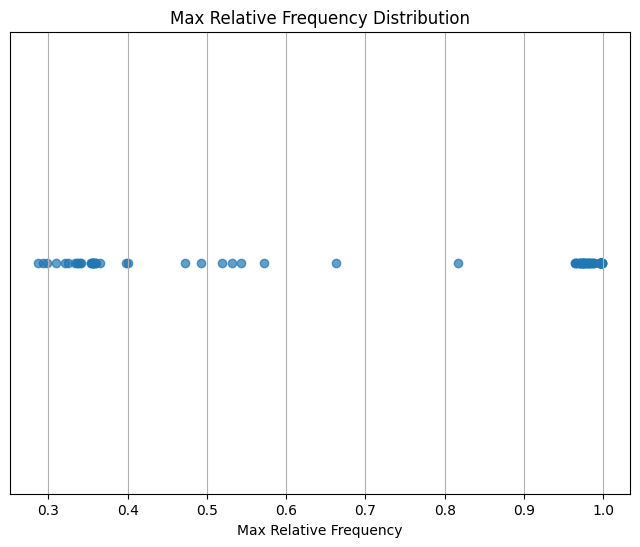

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the 'result_df' DataFrame from the previous code snippet.

# Plot the data directly using 'max_relative_frequency'
plt.figure(figsize=(8, 6))
plt.scatter(result_df['max_relative_frequency'], [0] * len(result_df), alpha=0.7)
plt.xlabel('Max Relative Frequency')
plt.yticks([])
plt.title('Max Relative Frequency Distribution')
plt.grid(True)
plt.show()

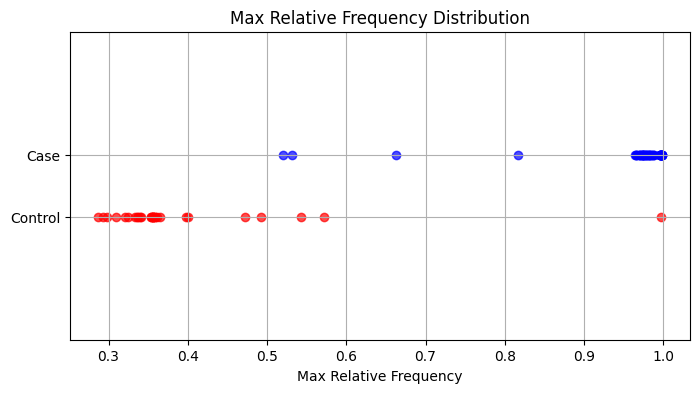

diagnosis
Case                 47
Control (Healthy)    29
Name: count, dtype: int64


In [10]:
plt.figure(figsize=(8, 4))

plt.scatter(result_df[result_df['diagnosis']
            == 'Case']['max_relative_frequency'], 
            [.6] * result_df['diagnosis'].eq('Case').sum(), 
            color='blue', alpha=0.7, label='Case')
plt.scatter(result_df[result_df['diagnosis'] 
            == 'Control (Healthy)']['max_relative_frequency'], 
            [.4] * result_df['diagnosis'].eq('Control (Healthy)').sum(), 
            color='red', alpha=0.7, label='Control')

plt.xlabel('Max Relative Frequency')

plt.title('Max Relative Frequency Distribution')
#plt.legend()
plt.grid(True)
plt.ylim(0, 1)
plt.yticks([.4, .6], ['Control', 'Case'])
plt.show()
print(result_df['diagnosis'].value_counts())

In [11]:
print(result_df['max_relative_frequency'].min())
print(result_df['max_relative_frequency'].max())

0.28704692329305986
0.9983179142136249


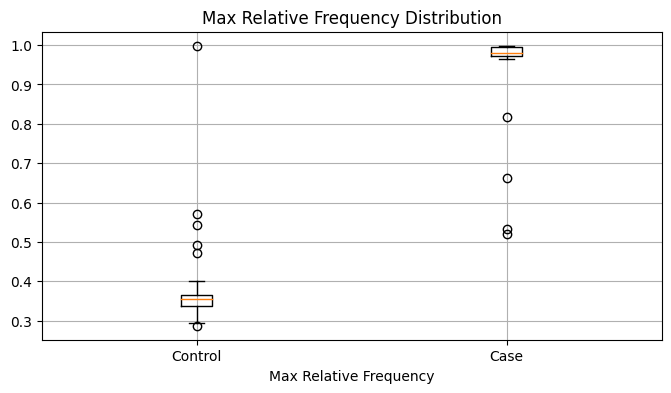

diagnosis
Case                 47
Control (Healthy)    29
Name: count, dtype: int64


In [12]:
plt.figure(figsize=(8, 4))

# Scatter plots

# Box plot
plt.boxplot([result_df[result_df['diagnosis'] == 'Control (Healthy)']['max_relative_frequency'],
             result_df[result_df['diagnosis'] == 'Case']['max_relative_frequency']], 
             labels=['Control', 'Case'], widths=0.1)

plt.xlabel('Max Relative Frequency')
plt.title('Max Relative Frequency Distribution')

plt.grid(True)
#plt.ylim(0, 1)

plt.show()

print(result_df['diagnosis'].value_counts())

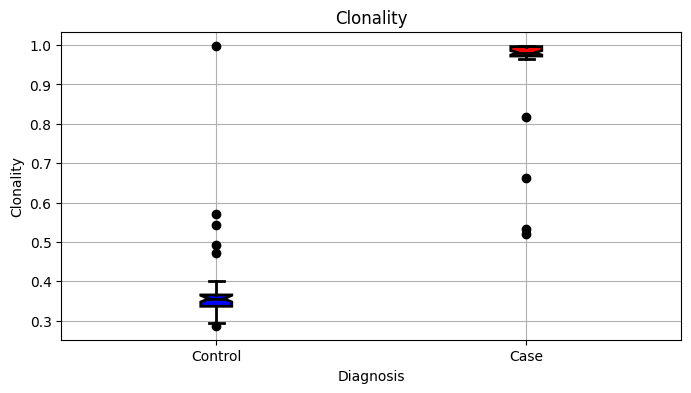

diagnosis
Case                 47
Control (Healthy)    29
Name: count, dtype: int64


In [13]:
#box plot
import matplotlib.pyplot as plt

# Assuming you have the 'result_df' DataFrame from the previous code snippet.

plt.figure(figsize=(8, 4))

# Box plot
boxprops = dict(linewidth=2, color='black')
medianprops = dict(linewidth=2, color='black')
capprops = dict(linewidth=2, color='black')
whiskerprops = dict(linewidth=2, color='black')
flierprops = dict(marker='o', markersize=6, markerfacecolor='black', markeredgecolor='black')

box_plot = plt.boxplot([result_df[result_df['diagnosis'] == 'Control (Healthy)']['max_relative_frequency'],
                        result_df[result_df['diagnosis'] == 'Case']['max_relative_frequency']],
                        labels=['Control', 'Case'], widths=0.1,
                        boxprops=boxprops, medianprops=medianprops, capprops=capprops, 
                        whiskerprops=whiskerprops, flierprops=flierprops,
                        patch_artist=True, showfliers=True, notch=True)

# Set the colors for the boxes
box_colors = ['blue', 'red']
for patch, color in zip(box_plot['boxes'], box_colors):
    patch.set_facecolor(color)

plt.xlabel('Diagnosis')
plt.ylabel('Clonality')
plt.title('Clonality')

plt.grid(True)
#plt.ylim(0, 1)

plt.show()

print(result_df['diagnosis'].value_counts())

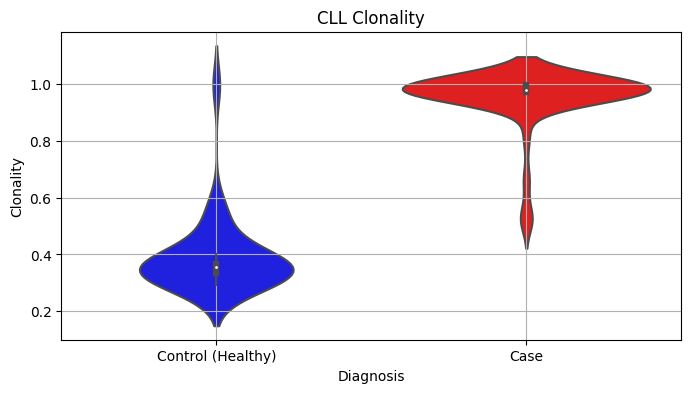

diagnosis
Case                 47
Control (Healthy)    29
Name: count, dtype: int64


In [14]:
import seaborn as sns

# Assuming you have the 'result_df' DataFrame from the previous code snippet.

plt.figure(figsize=(8, 4))

# Violin plot
sns.violinplot(x='diagnosis', y='max_relative_frequency', 
               data=result_df, order=['Control (Healthy)', 
                                      'Case'], palette=['blue', 'red'])

plt.xlabel('Diagnosis')
plt.ylabel('Clonality')
plt.title('CLL Clonality')

plt.grid(True)
plt.show()

print(result_df['diagnosis'].value_counts())

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming you have the 'result_df' DataFrame from the previous code snippet.

# Assuming 'group' column exists in 'result_df' and contains 'case' or 'control' labels
result_df_encoded = pd.get_dummies(result_df, columns=['diagnosis'], drop_first=True)

# Separate the features ('max_relative_frequency', and 'group_case') for PCA
features = result_df_encoded[['max_relative_frequency', 'group_diagnosis']]

# Perform PCA with the desired number of components (let's say 2 components for visualization)
num_components = 2
pca = PCA(n_components=num_components)
pca_result = pca.fit_transform(features)

# Create a DataFrame to store the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i + 1}' for i in range(num_components)])

# Add the 'repertoire_id', 'diagnosis', and 'v_subgroup' columns back to the PCA DataFrame
pca_df[['repertoire_id', 'diagnosis', 'v_subgroup']] = result_df_encoded[['repertoire_id', 'diagnosis', 'v_subgroup']]

# Plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_df[pca_df['group_case_case'] == 1]['PC1'], pca_df[pca_df['group_case_case'] == 1]['PC2'], label='Case', alpha=0.7)
plt.scatter(pca_df[pca_df['group_case_control'] == 0]['PC1'], pca_df[pca_df['group_case_control'] == 0]['PC2'], label='Control', alpha=0.7)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')
plt.legend()
plt.grid(True)
plt.show()

KeyError: "['group_diagnosis'] not in index"